<div class="alert alert-block alert-info">
    This script <b> calculates transgression levels for multiple PBs and adjusts prices from <code>EUR2005</code> to <code>USD2018</code></b>.
    <hr> 
    Note: <br>
    <i><b>Input file(s)' name(s) and metadata</b></i> (if available) are <b>printed out (below 👇🏼) in 'read data to df' section.</b>

In [1]:
# %env
# %who_ls
# %who
# %who int
# %pinfo <var name>

# Imports

In [2]:
%config IPCompleter.use_jedi = False # disable jedi autocompleter (https://stackoverflow.com/a/65734178/14485040)

import project_path  # makes possible the access to `src` directory using relative path
from src.data import (
    calculate_transgression_pb,
    internal_funcs,
    transform_from_eur_to_usd,
)
from src.utils import explore_dir, make_readme_info
from src.utils import read_excel_to_pandas as r_excel
from src.utils import set_outputs_dir
from src.utils import write_pandas_to_excel as w_excel

%run init_nb.ipynb

In [3]:
pd.options.display.max_columns = None

# INPUTS: Identify file(s) and read data to df

In [4]:
# Explore the directory to find the file(s)
inputs_dir, files_list = explore_dir(
    path_to_dir=r"..\data\interim", file_extension="xlsx", print_files_list=True
)

['CPC33to36_other_chemicals.xlsx',
 'data-extended-added-transgression-pbs.xlsx',
 'data-extended-glo-markets-and-fu-kg.xlsx',
 'data-filtered-cpc-33to36-divisions.xlsx',
 'data-regrouped-cpc-divisions-into-3-categories.xlsx',
 'df_chemproperties.xlsx',
 'extended-data-chosen-methods-metadata-pubchem-properties.xlsx',
 'lcia-results-from-sp910-combined.xlsx',
 'list-chemicals-not-shown-on-fig-prices-vs-impacts.xlsx',
 'list-chemicals-not-shown-on-fig3.xlsx',
 'list-outliers.xlsx',
 'mapped-lcia-results.xlsx',
 'pubchem-properties.xlsx',
 'raw-data-chosen-lcia-methods-and-metadata.xlsx',
 'temp-df_base_full_wCAS.xlsx',
 'temp-df_base_full_wCAS_woOutliersRMDk9a5.xlsx',
 'temp-dict_fullMethods.xlsx',
 'to-check-regrouped-data-other-chemicals-category.xlsx']


In [5]:
# Read data
df_base = r_excel(inputs_dir, "data-extended-glo-markets-and-fu-kg.xlsx")
print(
    "df_base".ljust(40, "."), f"{df_base.shape}\n".rjust(13, "."),
)

# Get list of LCIA methods and list of metadata
METHODS = r_excel(
    inputs_dir,
    "data-extended-glo-markets-and-fu-kg.xlsx",
    sheets="METHODS",
    show_readme=False,
)["METHODS"].to_list()

METADATA = r_excel(
    inputs_dir,
    "data-extended-glo-markets-and-fu-kg.xlsx",
    sheets="METADATA",
    show_readme=False,
)["METADATA"].to_list()


===> Trying to load 'readme' data... ===
File: data-extended-glo-markets-and-fu-kg.xlsx from
C:\Users\ViteksPC\Documents\00-ETH_projects\17-AESA_ecoinvent_chemicals\notebooks\0.40-vt-add-glo-markets-filter-kg-glo.ipynb
Generated on 2021-08-02 (Monday), 12:31:56 by Tulus, V.
Includes:
<<<
Sheet1: Extended dataframe, which includes pseudo-glo markets created from mass allocation of non-glo markets, and filtered by geo=GLO and FU=kg.
METADATA: list of relevant metadata used in Sheet1.
METHODS: list of LCIA methods used in Sheet1.
[METHODS + METADATA have to be the only column labels in Sheet1]
>>>

df_base................................. ...(668, 39)



# Operations

## Convert `df_base.referenceProduct_price` from EUR2005 to USD2018
<div class="alert alert-block alert-info">
updated: <code>df_base</code>
</div>

In [6]:
print(
    "There are {} unique price units in the DataFrame. And they are:".format(
        df_base.referenceProduct_priceUnit.nunique()
    )
)
pprint.pprint(list(df_base.referenceProduct_priceUnit.unique()))

There are 1 unique price units in the DataFrame. And they are:
['EUR2005']


In [7]:
# change from EUR2005 to USD2018, update df_base
new_prices, new_priceUnit = transform_from_eur_to_usd(
    prices_in=df_base.referenceProduct_price,
    currency_in=df_base.referenceProduct_priceUnit[0],
    year_out=2018,
    usd_per_eur=1.1811, # average exchange rate for 2018
    adjust_inflation=True,
)

df_base.referenceProduct_price = new_prices
df_base.referenceProduct_priceUnit = new_priceUnit

You transformed the prices from EUR2005 to USD2018 and applied an adjustment for inflation using Producer Price Index for years 2005-2018


C:\Users\ViteksPC\Documents\00-ETH_projects\17-AESA_ecoinvent_chemicals\src\data\transform_from_eur_to_usd.py:94: UserWarning: (!) Make sure that passed `usd_per_eur=1.1811` is for 2018

  warnings.warn("(!) Make sure that passed `usd_per_eur={}` is for {}\n"


## Add transgression levels (TLs) to `df_base`
<div class="alert alert-block alert-info">
    created: <code>df_base_full</code>  
</div> 

In [8]:
df_base_full, TL_METHODS = calculate_transgression_pb(
    df_in=df_base, sharing_principle="epc",  # [METADATA + METHODS],  # equal-per-capita
)

print(
    "Created **df_base_full** dataframe is of {} shape."
    "\nAnd contains these {} new methods:".format(df_base_full.shape, len(TL_METHODS))
)
pprint.pprint(TL_METHODS)
print("\n(make sure to store these methods for later use)\n")
df_base_full.tail(5)


# NOW THIS FUNCTION RETURNS THE PASSED DF + NEW TL COLUMNS, AND LIST OF TL COLUMNS
# MAKE SURE TO CHECK THIS FURTHER

# ALSO ARE AVIALABLE DICTS WITH SOS AND CURRENT PB VALUES... USE THEM

Created **df_base_full** dataframe is of (668, 48) shape.
And contains these 9 new methods:
["(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 "
 "concentration', 'ppm')",
 "(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy "
 "imbalance', 'Wm-2')",
 "(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', "
 "'DU')",
 "(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega "
 "Aragon')",
 "(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg "
 "P')",
 "(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg "
 "N')",
 "(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', "
 "'%')",
 "(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')",
 "(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - "
 "BII loss', '% BII loss')"]

(make sure to store these methods for later use)



C:\Users\ViteksPC\Documents\00-ETH_projects\17-AESA_ecoinvent_chemicals\src\data\calculate_transgression_pb.py:113: UserWarning: With `sharing_principle='epc' you are using the default `gva_world=7.38e13` (USD2018) parameter. Make sure the currency of used prices is also USD2018.
  warnings.warn("With `sharing_principle='epc' you are using the "


,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,MF,MW,complexity,iupac,num_matches,pubchem_match,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","(epc) TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"
663,"Zeolite, slurry, without water, in 50% solutio...",Other chemical,NaN,Products,"Zeolite, slurry, without water, in 50% solutio...",Chemicals\Washing agents\Builders\Market,NaN,GLO,"2023:Manufacture of soap and detergents, clean...",NaN,NaN,1,kg,4.000000e+00,NaN,1.492581,USD2018,NaN,1318-02-1,"353: Soap, cleaning preparations, perfumes and...","Combined activity, mass allocated from RER, Ro...",NaN,Al2O5Si,162.050,52.4,dioxosilane;oxo(oxoalumanyloxy)alumane,1.0,by CAS,"['Aluminosilicate', '1318-02-1', 'Kaolinite, n...",2.394511,5.976450e-11,8.029013e-13,1.326030e-14,1.826249e-13,8.884009e-15,4.273545e-12,2.813792e-16,3.355402e-12,5.669645e-13,41.042075,39.699099,0.045217,13.086679,0.044370,3.408122,0.000557,0.041477,2.803331
664,"Diethyl ether, without water, in 99.95% soluti...",Organic chemical,NaN,Products,"Diethyl ether, without water, in 99.95% soluti...",Chemicals\Organic\Market,NaN,GLO,2011:Manufacture of basic chemicals,NaN,NaN,1,kg,1.889956e+07,NaN,1.607395,USD2018,NaN,60-29-7,"34170: Ethers, alcohol peroxides, ether peroxi...","Combined activity, mass allocated from RoW loc...",NaN,C4H10O,74.120,11.1,ethoxyethane,1.0,by CAS,"['DIETHYL ETHER', 'ether', 'Ethyl ether', 'Eth...",5.560823,1.312176e-10,1.771425e-12,2.863007e-14,4.009664e-13,6.437446e-13,1.978399e-12,6.452035e-16,1.110460e-11,1.312028e-12,83.674532,81.331096,0.090654,26.680425,2.985467,1.465062,0.001185,0.127461,6.023887
665,"Silicon tetrachloride, combined to GLO market",Inorganic chemical,NaN,Products,Silicon tetrachloride,Chemicals\Inorganic\Market,NaN,GLO,2011:Manufacture of basic chemicals,NaN,NaN,1,kg,3.764650e+08,NaN,19.805399,USD2018,NaN,10026-04-7,342: Basic inorganic chemicals n.e.c.,"Combined activity, mass allocated from RoW loc...",NaN,Cl4Si,169.900,19.1,tetrachlorosilane,1.0,by CAS,"['Tetrachlorosilane', 'SILICON TETRACHLORIDE',...",2.976041,7.383021e-11,9.901631e-13,1.842824e-14,2.256061e-13,2.480280e-15,7.372767e-13,6.609219e-16,6.604953e-12,7.119144e-13,3.820977,3.689602,0.004736,1.218357,0.000934,0.0

category_regrouped
Organic chemical      320
Other chemical        183
Inorganic chemical    165
dtype: int64
Total:  668

Shares in % for  category_regrouped
Inorganic chemical    24.7
Organic chemical      47.9
Other chemical        27.4
dtype: float64


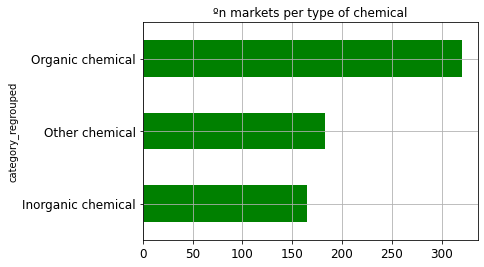

In [9]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base_full,
    groupby="category_regrouped",
    color="green",
    fontsize=12,
)

In [10]:
# Make df of METADATA, METHODS, and TL_METHODS for later export
df_metadata = pd.DataFrame(METADATA, columns=["METADATA"])
df_methods = pd.DataFrame(METHODS, columns=["METHODS"])
df_tl_methods = pd.DataFrame(TL_METHODS, columns=["TL_METHODS"])

# OUTPUTS: Export data to excel

In [11]:
%%time

# Set output directory
outputs_dir = set_outputs_dir(use_default=True)  # default `..\data\interim`

## Export dataframe to excel
excelName = "data-extended-added-transgression-pbs.xlsx"

df_readme = make_readme_info(
    excelName,
    "Sheet1: Extended dataframe, which also includes 9 transgression level (TL) PBs."
    "\nMETADATA: list of relevant metadata used in Sheet1."
    "\nMETHODS: list of LCIA methods used in Sheet1."
    "\nTL_METHODS: list of TL in PBs used in Sheet1."
    "\n[METHODS + METADATA + TL_METHODS have to be the only column labels in Sheet1]",
)

w_excel(
    path_to_file=outputs_dir,
    filename=excelName,
    dict_data_to_write={
        "Sheet1": df_base_full,
        "METADATA": df_metadata,
        "METHODS": df_methods,
        "TL_METHODS": df_tl_methods,
    },
    readme_info=("readme", df_readme),
    #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
    #     startrow=0
)

File: data-extended-added-transgression-pbs.xlsx successfully created in 
C:\Users\ViteksPC\Documents\00-ETH_projects\17-AESA_ecoinvent_chemicals\data\interim
Wall time: 1.11 s
